In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
from torchvision import transforms

import os
import zipfile
from pathlib import Path
import requests
import glob

try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary



In preparation for your mission, you've been fitted with a new visual cortex chip that is able to recognize common objects on Earth. To verify it's working correctly, run through a diagnostic test to see if you can distinguish people from large man-made constructions.

In [2]:
# import modules
directory = Path("modules")

if not os.path.exists(directory):
  os.makedirs(directory)

download_modules = {
    "vision_chip_model.py":"https://raw.githubusercontent.com/Q-b1t/RNN_EXP/main/vc_modules/model.py",
    "meta":"https://github.com/Q-b1t/htbml/raw/main/VISION_CHIP/meta",
    "state_dict.pt":"https://github.com/Q-b1t/htbml/raw/main/VISION_CHIP/state_dict.pt"
}

file_paths = dict()

for module,raw in download_modules.items():
  module_path = directory / module
  file_paths[module] = module_path  
  if(module_path.exists()):
    print(f"[INFO]: Module: {module_path} already exists. Skipping...")
  else:
    print(f"[INFO]: Downloading {module}")
    request = requests.get(raw)
    with open(module_path,"wb") as f:
      f.write(request.content)

[INFO]: Module: modules/vision_chip_model.py already exists. Skipping...
[INFO]: Module: modules/meta already exists. Skipping...
[INFO]: Module: modules/state_dict.pt already exists. Skipping...


In [3]:
#from model import EarthVisionModel
from modules.vision_chip_model import EarthVisionModel

In [4]:
# download test dataset

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "x_test"
source = "https://github.com/Q-b1t/RNN_EXP/raw/main/vc_modules/test_X.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"[INFO] {image_path} directory exists, skipping download.")
else:
    print(f"[INFO] Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
        request = requests.get(source)
        print(f"[INFO] Downloading {target_file} from {source}...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
        print(f"[INFO] Unzipping {target_file} data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / target_file)
        

[INFO] data/x_test directory exists, skipping download.


In [5]:
image_path

PosixPath('data/x_test')

In [6]:
model_weights_path = file_paths["state_dict.pt"]
model_metadata_path = file_paths["meta"]
# model_metadata_path =  "./meta" -> local

In [7]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        _dict = pickle.load(fo, encoding='bytes')
    return _dict

label_meta = unpickle(model_metadata_path)

In [8]:
label_meta_keys = label_meta.keys()
label_meta_values = label_meta.values()

In [9]:
label_meta_keys

dict_keys([b'fine_label_names', b'coarse_label_names', b'label_map'])

### Dataset Classes:

In [10]:
# this are the labels we will be using. 
fine_label_names = [label.decode("utf-8") for label in label_meta[b'fine_label_names']]
len(fine_label_names)

100

In [11]:
fine_label_names

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

### Important Information
It seems the test data are an extract from the [CIFAR 100 Dataset](https://gist.github.com/NeuralNetworkingTechnologies/bf458b4607d327a5eb86a646c4f4d589)

In [12]:
label_meta_values

dict_values([[b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'mouse', b'mushroom', b'oak_tree', b'orange', b'orchid', b'otter', b'palm_tree', b'pear', b'pickup_truck', b'pine_tree', b'plain', b'plate', b'poppy', b'porcupine', b'possum', b'rabbit', b'raccoon', b'ray', b'road', b'rocket', b'rose', b'sea', b'seal', b'shark', b'shrew', b'skunk', b'skyscraper', b'snail', b'snake', b'spider', b'squirrel', b'streetcar', b'sunflower', b'sweet_pepper', b'table', b'tank', b'telephone', b'tele

In [13]:
len(label_meta_keys),len(label_meta_values)

(3, 3)

# Create Custom Dataset



In [14]:
# test_file path
test_path =  image_path
test_path

PosixPath('data/x_test')

In [15]:
# returns the list of class names and a dictionary that maps each class name to a specific index
def find_classes(label_names):
  return label_names,{class_name:i for i,class_name in enumerate(label_names)}

In [16]:
# preprocessing data transform proposed by the challenge
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [17]:
def get_image_paths(target_path,sort = True):
  img_list = list(Path(target_path).glob("*/*.jpg"))
  if sorted:
    img_list = sorted(img_list,key = lambda x : int(str(x).split("/")[-1].split(".")[0]))
  return img_list

In [18]:
from torch.nn.modules.distance import PairwiseDistance
# custom dataset
class EarthVisionDataset(Dataset):
  def __init__(self,target_dir,transform = preprocess,sort_img_paths = True,label_names = fine_label_names):
    # fetch all the image paths
    self.img_paths = get_image_paths(target_dir,sort_img_paths)
    # setup transform
    self.transform = transform
    # create classes and class_to_idx
    self.classes,self.class_to_idx = find_classes(label_names)
  
  # load and image
  def load_image(self,index):
    image_path = self.img_paths[index]
    return Image.open(image_path)
  
  # essential overwrites
  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self,index):
    img = self.load_image(index)
    return self.transform(img)

In [19]:
# instance custom dataset
test_dataset = EarthVisionDataset(test_path)

In [20]:
test_dataset.__len__()

8192

In [21]:
test_dataset.classes[:10]

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle']

In [22]:
test_dataset.img_paths[:10]

[PosixPath('data/x_test/test_X/0.jpg'),
 PosixPath('data/x_test/test_X/1.jpg'),
 PosixPath('data/x_test/test_X/2.jpg'),
 PosixPath('data/x_test/test_X/3.jpg'),
 PosixPath('data/x_test/test_X/4.jpg'),
 PosixPath('data/x_test/test_X/5.jpg'),
 PosixPath('data/x_test/test_X/6.jpg'),
 PosixPath('data/x_test/test_X/7.jpg'),
 PosixPath('data/x_test/test_X/8.jpg'),
 PosixPath('data/x_test/test_X/9.jpg')]

# Instance Dataloader

In [23]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
test_dataloader = DataLoader(
    dataset = test_dataset, 
    batch_size = BATCH_SIZE, 
    num_workers=NUM_WORKERS,
    shuffle = False
    )



In [24]:
next(iter(test_dataloader)).shape

torch.Size([32, 3, 32, 32])

# Testing the Model

In [25]:
model = EarthVisionModel()
model.load_state_dict(torch.load(f=model_weights_path))

<All keys matched successfully>

In [26]:
summary(model,input_size=list(next(iter(test_dataloader)).shape))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV2                                   [32, 100]                 --
├─Sequential: 1-1                             [32, 1792, 4, 4]          --
│    └─ConvBNActivation: 2-1                  [32, 48, 32, 32]          --
│    │    └─Conv2d: 3-1                       [32, 48, 32, 32]          1,296
│    │    └─BatchNorm2d: 3-2                  [32, 48, 32, 32]          96
│    │    └─ReLU6: 3-3                        [32, 48, 32, 32]          --
│    └─InvertedResidual: 2-2                  [32, 24, 32, 32]          --
│    │    └─Sequential: 3-4                   [32, 24, 32, 32]          1,728
│    └─InvertedResidual: 2-3                  [32, 32, 32, 32]          --
│    │    └─Sequential: 3-5                   [32, 32, 32, 32]          10,000
│    └─InvertedResidual: 2-4                  [32, 32, 32, 32]          --
│    │    └─Sequential: 3-6                   [32, 32, 32, 32]          14,848
│    └

In [27]:
# making predictions

# tensor used to store the prediciton indexes
prediction_indexes = torch.zeros((test_dataset.__len__()),dtype = torch.int32)

# position placeholder
position = 0

model.eval()
with torch.inference_mode():
  # loop through the batches in the dataloader
  for batch, X in enumerate(tqdm(test_dataloader)):
    # forward pass
    y_logits = model(X)
    # predict labels
    y_labels  = y_logits.argmax(dim = 1) 
    # update the tensor
    prediction_indexes[position:position+BATCH_SIZE] += y_labels
    position += BATCH_SIZE

  0%|          | 0/256 [00:00<?, ?it/s]

In [28]:
prediction_indexes[:100]

tensor([12, 17,  9, 12, 17, 31, 17, 12, 17, 84, 33, 76, 12, 76, 68, 37, 76, 37,
        37, 68,  5, 12, 12, 12, 37, 37, 37, 37, 37, 81, 37, 37, 17, 63, 76, 68,
        17, 56, 76, 17, 76, 37, 33, 17, 17, 76, 17, 76, 12, 68, 37, 17, 17, 37,
        84, 37, 76, 12, 81, 17, 68, 37, 12, 68, 37, 37, 12, 17, 12, 17, 12, 17,
        12, 12, 12, 37, 68, 17, 69, 76, 97, 12, 12, 12, 76, 37, 37, 12, 76, 17,
        37, 76, 68, 76, 37, 12, 17, 33, 37, 76], dtype=torch.int32)

# Theory
THere are 8192 images in the test dataset, and the flag image contains the same number of pixels. Since it is a grayscale image, we have to see how many images are classified with labels semantically related to "person" and set the flag's pixel values accordingly. <br/>
- person: 255
- other: 0
### Ideas
- Custom Dataset
- Dataloader
- Evaluate
- Predict
- torch.reshape((32,100))

### Person classes
- 2
- 11
- 35
- 46
- 98

In [29]:
test_dataset.class_to_idx

{'apple': 0,
 'aquarium_fish': 1,
 'baby': 2,
 'bear': 3,
 'beaver': 4,
 'bed': 5,
 'bee': 6,
 'beetle': 7,
 'bicycle': 8,
 'bottle': 9,
 'bowl': 10,
 'boy': 11,
 'bridge': 12,
 'bus': 13,
 'butterfly': 14,
 'camel': 15,
 'can': 16,
 'castle': 17,
 'caterpillar': 18,
 'cattle': 19,
 'chair': 20,
 'chimpanzee': 21,
 'clock': 22,
 'cloud': 23,
 'cockroach': 24,
 'couch': 25,
 'crab': 26,
 'crocodile': 27,
 'cup': 28,
 'dinosaur': 29,
 'dolphin': 30,
 'elephant': 31,
 'flatfish': 32,
 'forest': 33,
 'fox': 34,
 'girl': 35,
 'hamster': 36,
 'house': 37,
 'kangaroo': 38,
 'keyboard': 39,
 'lamp': 40,
 'lawn_mower': 41,
 'leopard': 42,
 'lion': 43,
 'lizard': 44,
 'lobster': 45,
 'man': 46,
 'maple_tree': 47,
 'motorcycle': 48,
 'mountain': 49,
 'mouse': 50,
 'mushroom': 51,
 'oak_tree': 52,
 'orange': 53,
 'orchid': 54,
 'otter': 55,
 'palm_tree': 56,
 'pear': 57,
 'pickup_truck': 58,
 'pine_tree': 59,
 'plain': 60,
 'plate': 61,
 'poppy': 62,
 'porcupine': 63,
 'possum': 64,
 'rabbit': 65,

In [30]:
predictions_maleable = prediction_indexes.numpy()

In [31]:
predictions_maleable.shape,predictions_maleable.dtype

((8192,), dtype('int32'))

In [32]:
# indexes with "persons"
person_indexes = [2,11,35,46,48,98]

In [33]:
grayscale = [255 if pred in person_indexes else 0 for pred in predictions_maleable]

In [34]:
grayscale_matrix = np.array(grayscale)

In [35]:
grayscale_matrix.shape

(8192,)

In [36]:
grayscale_matrix[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
flag = np.zeros((32,256))

In [38]:
grayscale_matrix = grayscale_matrix.copy().reshape(flag.shape)

In [39]:
32 * 256 

8192

In [40]:
flag += grayscale_matrix

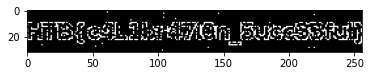

In [41]:
plt.imshow(flag, cmap="gray")
plt.show()